# SponsorBlock Dataset - Phân tích và Tiền xử lý

Notebook này thực hiện:
1. Phân tích dữ liệu từ SponsorBlock dataset
2. Tiền xử lý dữ liệu SponsorBlock
3. Chuyển đổi transcript từ JSON sang DataFrame
4. Kết hợp hai bộ dữ liệu để gán nhãn transcript
5. Lưu kết quả dưới dạng Parquet

In [1]:
import pandas as pd
import os
import json
import re
import numpy as np
from tqdm import tqdm
from datetime import datetime
from typing import List, Dict, Any, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn dữ liệu
sponsor_dataset = r"C:\Users\caotr\Downloads\transcript_data\sponsorTimes.parquet"
video_info_dataset = r"C:\Users\caotr\Downloads\transcript_data\videoInfo.csv"
transcript_folder = r"C:\Users\caotr\Downloads\transcript_data\transcripts"

# Đường dẫn lưu kết quả
output_folder = r"C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw"
os.makedirs(output_folder, exist_ok=True)

## 1. Phân tích dữ liệu SponsorBlock

Đầu tiên, chúng ta sẽ phân tích dữ liệu từ SponsorBlock để hiểu cấu trúc và đặc điểm của nó.

In [2]:
# Đọc dữ liệu sponsor
sponsor_df = pd.read_parquet(sponsor_dataset)

# Xem thông tin cơ bản
print("===== THÔNG TIN CƠ BẢN =====")
sponsor_df.info()
print("\n===== 5 DÒNG ĐẦU TIÊN =====")
display(sponsor_df.head())

===== THÔNG TIN CƠ BẢN =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16493888 entries, 0 to 16493887
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   videoID         object 
 1   startTime       float64
 2   endTime         float64
 3   votes           int64  
 4   locked          int64  
 5   incorrectVotes  int64  
 6   UUID            object 
 7   userID          object 
 8   timeSubmitted   int64  
 9   views           int64  
 10  category        object 
 11  actionType      object 
 12  service         object 
 13  videoDuration   float64
 14  hidden          int64  
 15  reputation      float64
 16  shadowHidden    int64  
 17  hashedVideoID   object 
 18  userAgent       object 
 19  description     object 
dtypes: float64(4), int64(7), object(9)
memory usage: 2.5+ GB

===== 5 DÒNG ĐẦU TIÊN =====


,videoID,startTime,endTime,votes,locked,incorrectVotes,UUID,userID,timeSubmitted,views,category,actionType,service,videoDuration,hidden,reputation,shadowHidden,hashedVideoID,userAgent,description
0,1rb3bMvDdX4,588.94100,631.89777,159,0,1,28aff450-a372-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,4642,sponsor,skip,YouTube,0.0,0,0.0,0,95e409452186a56331b7a58d518361285e18b8db50de20...,None,None
1,fBxtS9BpVWs,41.00000,53.00000,115,0,1,b2465943-1313-449c-b75c-08b14756ac0a,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,776,sponsor,skip,YouTube,0.0,0,0.0,0,bdd81b2b8192683242fe3608c45d5b958ddc71e9b2981a...,None,None
2,9P6rdqiybaw,488.52150,542.11035,-2,0,1,81024780-a367-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,25661,sponsor,skip,YouTube,552.0,0,0.0,0,cc9cd26ee245cb89f2be13d047de8ea1a642c8f56bcb6e...,None,None
3,ulCdoCfw-bY,487.50198,547.48750,-2,0,1,16090680-a367-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,26984,sponsor,skip,YouTube,0.0,0,0.0,0,177779136cde894988da5e2d3160ef38d302a8554d710d...,None,None
4,uqKGREZs6-w,475.52167,532.20874,302,0,1,622f9270-a2a1-11e9-b210-99c885575bb9,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,18060,sponsor,skip,YouTube,0.0,1,0.0,0,70f8d0e75affa202ab510bd86828080af1dddf9218be46...,None,None


In [3]:
# Phân tích thống kê mô tả
print("===== THỐNG KÊ MÔ TẢ =====")
describe_stats = sponsor_df.describe()
display(describe_stats)

# Kiểm tra giá trị null
print("\n===== GIÁ TRỊ NULL =====")
null_counts = sponsor_df.isnull().sum()
print(null_counts)

# Số lượng video duy nhất
unique_videos = sponsor_df['videoID'].nunique()
print(f"\nSố lượng video duy nhất: {unique_videos}")

===== THỐNG KÊ MÔ TẢ =====


,startTime,endTime,votes,locked,incorrectVotes,timeSubmitted,views,videoDuration,hidden,reputation,shadowHidden
count,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649389e+07,1.649383e+07,1.649389e+07
mean,9.234681e+02,9.732066e+02,2.764275e-01,2.726919e-02,1.000000e+00,1.674681e+12,4.744585e+02,2.153992e+03,2.303449e-01,2.065722e+00,5.149107e-02
std,1.707526e+04,1.959693e+04,8.939685e+00,1.628668e-01,8.877898e-04,3.779940e+10,4.193451e+03,8.296067e+03,6.308490e-01,6.274483e+00,2.209972e-01
min,-2.440000e+02,-6.400000e+01,-5.010000e+02,0.000000e+00,0.000000e+00,1.564089e+12,0.000000e+00,0.000000e+00,0.000000e+00,-2.500000e+00,0.000000e+00
25%,1.614000e+01,5.075400e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.652769e+12,1.000000e+00,3.850000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.910490e+02,2.363866e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.669894e+12,2.200000e+01,8.620000e+02,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.591000e+02,7.991320e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.705500e+12,1.650000e+02,1.969221e+03,0.000000e+00,0.000000e+00,0.000000e+00
max,3.837856e+07,3.840068e+07,9.994000e+03,1.000000e+00,3.000000e+00,1.742605e+12,1.876532e+06,2.533528e+07,2.000000e+00,2.700000e+01,1.000000e+00



===== GIÁ TRỊ NULL =====
videoID                 54
startTime                0
endTime                  0
votes                    0
locked                   0
incorrectVotes           0
UUID                     0
userID                   0
timeSubmitted            0
views                    0
category                 0
actionType               0
service                  0
videoDuration            0
hidden                   0
reputation              58
shadowHidden             0
hashedVideoID            0
userAgent          3275790
description       16268791
dtype: int64

Số lượng video duy nhất: 7704124
videoID                 54
startTime                0
endTime                  0
votes                    0
locked                   0
incorrectVotes           0
UUID                     0
userID                   0
timeSubmitted            0
views                    0
category                 0
actionType               0
service                  0
videoDuration            0
hidden   

### Phân tích phân bố dữ liệu

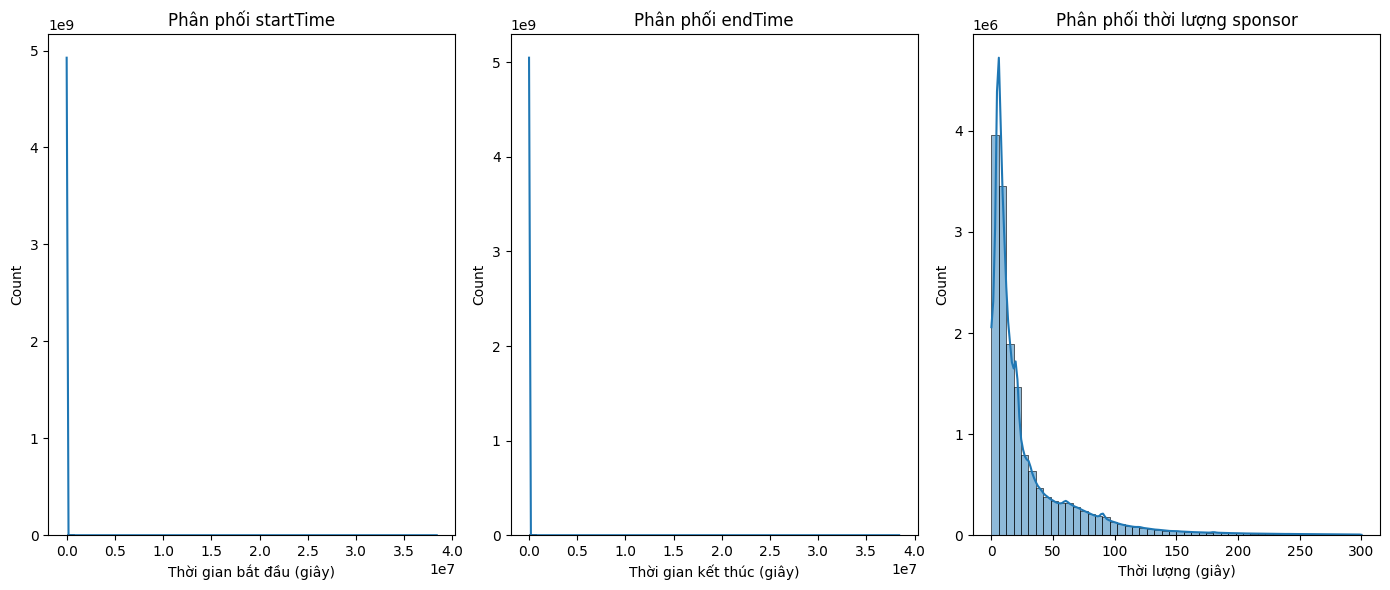

In [4]:
# Phân tích phân phối thời gian sponsor
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(sponsor_df['startTime'], bins=50, kde=True)
plt.title('Phân phối startTime')
plt.xlabel('Thời gian bắt đầu (giây)')

plt.subplot(1, 3, 2)
sns.histplot(sponsor_df['endTime'], bins=50, kde=True)
plt.title('Phân phối endTime')
plt.xlabel('Thời gian kết thúc (giây)')

plt.subplot(1, 3, 3)
sponsor_duration = sponsor_df['endTime'] - sponsor_df['startTime']
sns.histplot(sponsor_duration[sponsor_duration < 300], bins=50, kde=True)  # Chỉ hiển thị duration < 300s để dễ nhìn
plt.title('Phân phối thời lượng sponsor')
plt.xlabel('Thời lượng (giây)')

plt.tight_layout()
plt.show()

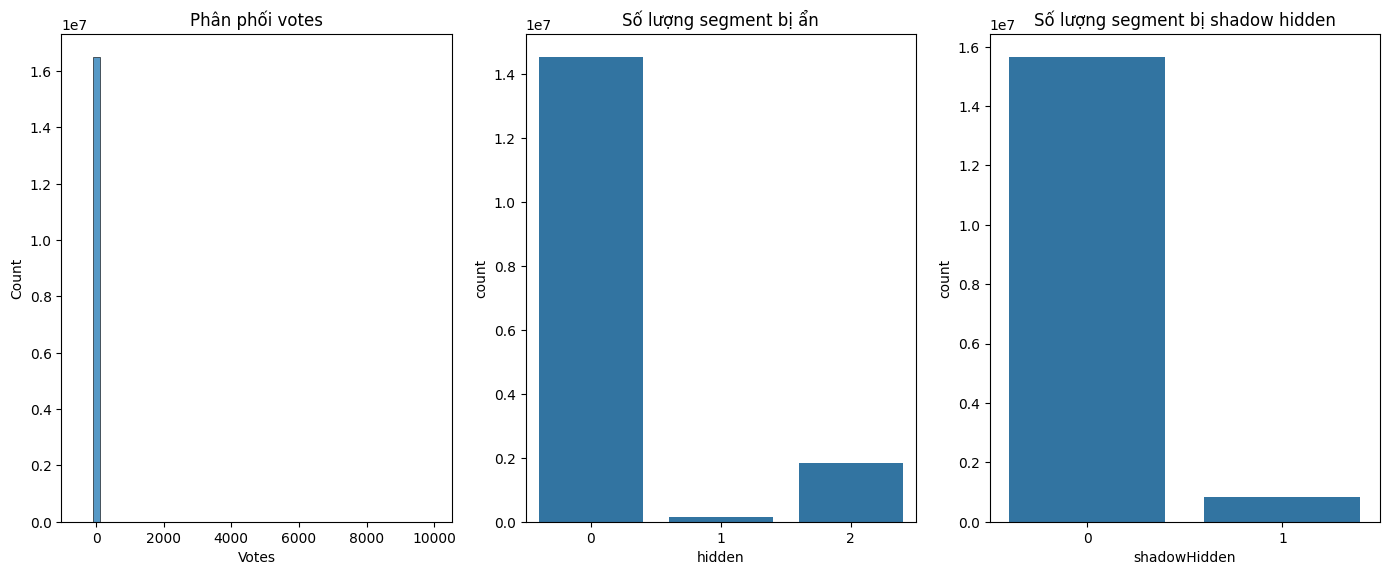

In [5]:
# Phân tích các trường khác
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(sponsor_df['votes'], bins=50)
plt.title('Phân phối votes')
plt.xlabel('Votes')

plt.subplot(1, 3, 2)
sns.countplot(x='hidden', data=sponsor_df)
plt.title('Số lượng segment bị ẩn')

plt.subplot(1, 3, 3)
sns.countplot(x='shadowHidden', data=sponsor_df)
plt.title('Số lượng segment bị shadow hidden')

plt.tight_layout()
plt.show()

### Phân tích các video có nhiều segments

Phân phối số lượng segment trên mỗi video:
count    7.704124e+06
mean     2.140910e+00
std      4.598526e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.860000e+02
Name: count, dtype: float64

Số lượng video có nhiều hơn 1 segment: 3136263
Tỷ lệ: 40.71%

Số lượng video có nhiều hơn 1 segment: 3136263
Tỷ lệ: 40.71%


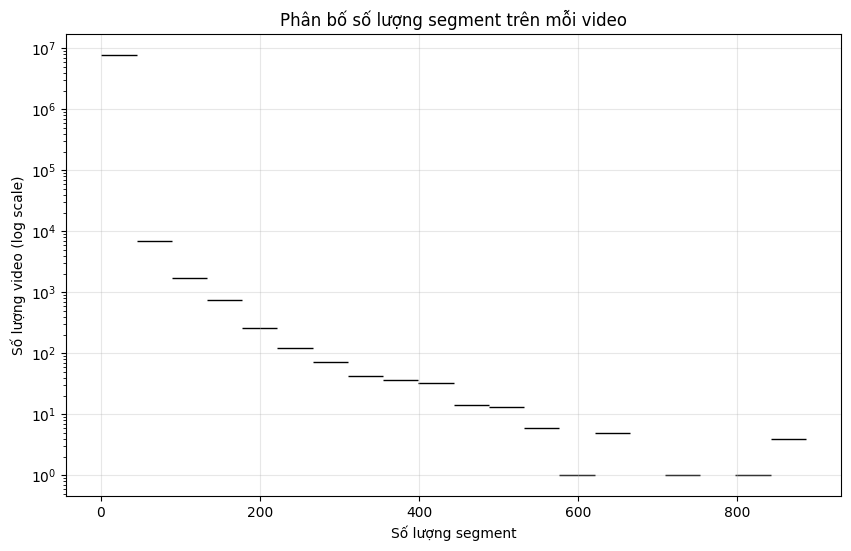

In [6]:
# Đếm số lượng segments trên mỗi video
video_counts = sponsor_df['videoID'].value_counts().reset_index()
video_counts.columns = ['videoID', 'count']

# Thống kê
print("Phân phối số lượng segment trên mỗi video:")
print(video_counts['count'].describe())

# Số lượng video có nhiều hơn 1 segment
multiple_segments = video_counts[video_counts['count'] > 1]
print(f"\nSố lượng video có nhiều hơn 1 segment: {len(multiple_segments)}")
print(f"Tỷ lệ: {len(multiple_segments) / len(video_counts) * 100:.2f}%")

# Phân bố số lượng segment
plt.figure(figsize=(10, 6))
sns.histplot(video_counts['count'], bins=20, log_scale=(False, True))
plt.title('Phân bố số lượng segment trên mỗi video')
plt.xlabel('Số lượng segment')
plt.ylabel('Số lượng video (log scale)')
plt.grid(True, alpha=0.3)
plt.show()

### Phân tích các trường hợp video có nhiều segment

In [7]:
# Hàm phân tích một video cụ thể
def analyze_video_segments(video_id):
    # Lấy tất cả các segment của video này
    video_segments = sponsor_df[sponsor_df['videoID'] == video_id].copy()
    
    # Sắp xếp theo thời gian bắt đầu
    video_segments = video_segments.sort_values('startTime')
    
    print(f"\nPhân tích video {video_id} có {len(video_segments)} segments:")
    
    # Kiểm tra các trường hợp
    
    # 1. Các segment có overlap về thời gian (có thể là gán lại do sai)
    overlaps = []
    for i in range(len(video_segments) - 1):
        for j in range(i + 1, len(video_segments)):
            s1_start, s1_end = video_segments.iloc[i]['startTime'], video_segments.iloc[i]['endTime']
            s2_start, s2_end = video_segments.iloc[j]['startTime'], video_segments.iloc[j]['endTime']
            
            # Kiểm tra overlap
            if (s1_start <= s2_end and s2_start <= s1_end):
                overlap_ratio = min(s1_end, s2_end) - max(s1_start, s2_start)
                overlap_ratio = overlap_ratio / min(s1_end - s1_start, s2_end - s2_start)
                
                if overlap_ratio > 0.5:  # Nếu overlap hơn 50%
                    overlaps.append((i, j, overlap_ratio))
    
    print(f"Số cặp segment có overlap > 50%: {len(overlaps)}")
    
    # 2. Kiểm tra các segment có cách xa nhau (có thể là các phân đoạn khác nhau)
    segments_info = []
    for i, row in video_segments.iterrows():
        segments_info.append({
            'start': row['startTime'],
            'end': row['endTime'],
            'duration': row['endTime'] - row['startTime'],
            'votes': row['votes'],
            'hidden': row['hidden'],
            'shadowHidden': row['shadowHidden']
        })
    
    separate_segments = True
    for i in range(len(segments_info) - 1):
        if segments_info[i+1]['start'] - segments_info[i]['end'] < 30:  # Nếu cách nhau dưới 30s
            separate_segments = False
            break
    
    print(f"Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): {separate_segments}")
    
    # 3. Kiểm tra có segment nào bị ẩn không
    hidden_segments = video_segments[(video_segments['hidden'] > 0) | (video_segments['shadowHidden'] > 0)]
    print(f"Số segment bị ẩn (hidden hoặc shadowHidden): {len(hidden_segments)}")
    
    # 4. Kiểm tra phiếu bầu
    high_vote_segments = video_segments[video_segments['votes'] > 10]
    low_vote_segments = video_segments[video_segments['votes'] < 0]
    print(f"Số segment có votes > 10: {len(high_vote_segments)}")
    print(f"Số segment có votes < 0: {len(low_vote_segments)}")
    
    return video_segments

# Lấy 3 video có nhiều segment nhất để phân tích
top_multi_videos = video_counts.sort_values('count', ascending=False).head(3)['videoID'].tolist()

for video_id in top_multi_videos:
    detailed_segments = analyze_video_segments(video_id)
    print("\nThông tin chi tiết về 3 segment đầu tiên:")
    display(detailed_segments[['startTime', 'endTime', 'votes', 'hidden', 'shadowHidden', 'timeSubmitted']].head(3))


Phân tích video SYd5F4gIH90 có 886 segments:
Số cặp segment có overlap > 50%: 0
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 886
Số segment có votes > 10: 0
Số segment có votes < 0: 0

Thông tin chi tiết về 3 segment đầu tiên:
Số cặp segment có overlap > 50%: 0
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 886
Số segment có votes > 10: 0
Số segment có votes < 0: 0

Thông tin chi tiết về 3 segment đầu tiên:


,startTime,endTime,votes,hidden,shadowHidden,timeSubmitted
5078846,184.859,190.640,0,2,0,1657903586130
5078538,220.380,232.239,0,2,0,1657903586130
5079286,292.619,308.320,0,2,0,1657903586130



Phân tích video ESC2oMp_RVE có 863 segments:
Số cặp segment có overlap > 50%: 0
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 863
Số segment có votes > 10: 0
Số segment có votes < 0: 0

Thông tin chi tiết về 3 segment đầu tiên:
Số cặp segment có overlap > 50%: 0
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 863
Số segment có votes > 10: 0
Số segment có votes < 0: 0

Thông tin chi tiết về 3 segment đầu tiên:


,startTime,endTime,votes,hidden,shadowHidden,timeSubmitted
7353984,8.90,22.56,0,0,1,1660759079794
7353983,79.14,84.32,0,0,1,1660759079794
7353982,85.86,99.92,0,0,1,1660759079794



Phân tích video hM101bVkyoo có 854 segments:
Số cặp segment có overlap > 50%: 1539
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 0
Số segment có votes > 10: 0
Số segment có votes < 0: 1

Thông tin chi tiết về 3 segment đầu tiên:
Số cặp segment có overlap > 50%: 1539
Các segment là các phân đoạn riêng biệt (cách nhau >= 30s): False
Số segment bị ẩn (hidden hoặc shadowHidden): 0
Số segment có votes > 10: 0
Số segment có votes < 0: 1

Thông tin chi tiết về 3 segment đầu tiên:


,startTime,endTime,votes,hidden,shadowHidden,timeSubmitted
12488403,53.0,109.0,0,0,0,1706665118036
12488339,109.0,138.0,0,0,0,1706665118036
12488400,138.0,172.0,0,0,0,1706665118036


C:\Users\caotr\AppData\Local\Temp\ipykernel_13080\2110138869.py:30: RuntimeWarning: invalid value encountered in scalar divide
  overlap_ratio = overlap_ratio / min(s1_end - s1_start, s2_end - s2_start)


Phân tích 100 video có 2-3 segment:
- Videos có các segment overlap (gán lại do sai): 14 (14.00%)
- Videos có các segment riêng biệt (nhiều đoạn quảng cáo): 62 (62.00%)
- Videos có ít nhất 1 segment bị ẩn: 1 (1.00%)
- Videos có segment với vote trái chiều: 0 (0.00%)
- Các trường hợp khác: 23 (23.00%)


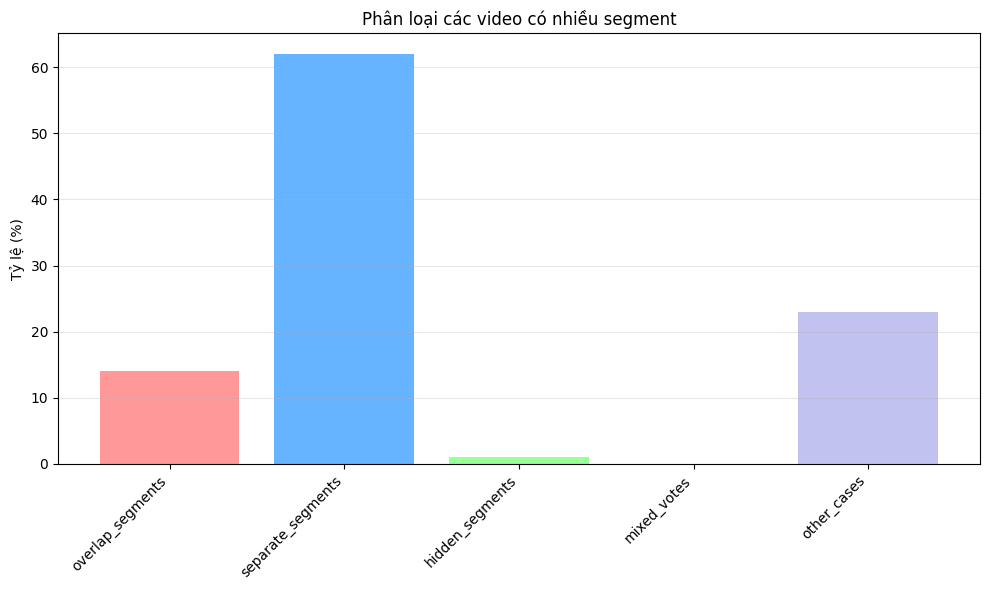

In [8]:
# Phân tích tổng hợp về các trường hợp phổ biến
def analyze_multiple_segment_cases(sample_size=100):
    # Lấy các video có 2-3 segment
    videos_with_few_segments = video_counts[(video_counts['count'] >= 2) & (video_counts['count'] <= 3)]
    
    # Lấy mẫu ngẫu nhiên
    sample_videos = videos_with_few_segments.sample(min(sample_size, len(videos_with_few_segments)))['videoID'].tolist()
    
    # Đếm các trường hợp
    cases = {
        'overlap_segments': 0,  # Trường hợp có các segment overlap (gán lại do sai)
        'separate_segments': 0,  # Trường hợp các segment riêng biệt (nhiều đoạn quảng cáo)
        'hidden_segments': 0,    # Trường hợp có ít nhất 1 segment bị ẩn
        'mixed_votes': 0,        # Trường hợp có cả segment vote dương và âm
        'other_cases': 0         # Các trường hợp khác
    }
    
    for video_id in sample_videos:
        video_segments = sponsor_df[sponsor_df['videoID'] == video_id].copy()
        
        # Kiểm tra overlap
        has_overlap = False
        for i in range(len(video_segments) - 1):
            for j in range(i + 1, len(video_segments)):
                s1_start, s1_end = video_segments.iloc[i]['startTime'], video_segments.iloc[i]['endTime']
                s2_start, s2_end = video_segments.iloc[j]['startTime'], video_segments.iloc[j]['endTime']
                
                if (s1_start <= s2_end and s2_start <= s1_end):
                    overlap_ratio = min(s1_end, s2_end) - max(s1_start, s2_start)
                    overlap_ratio = overlap_ratio / min(s1_end - s1_start, s2_end - s2_start)
                    
                    if overlap_ratio > 0.5:  # Nếu overlap hơn 50%
                        has_overlap = True
                        break
            if has_overlap:
                break
        
        # Kiểm tra các segment riêng biệt
        video_segments = video_segments.sort_values('startTime')
        all_separate = True
        for i in range(len(video_segments) - 1):
            s1_end = video_segments.iloc[i]['endTime']
            s2_start = video_segments.iloc[i+1]['startTime']
            if s2_start - s1_end < 30:  # Nếu cách nhau dưới 30s
                all_separate = False
                break
        
        # Kiểm tra hidden segments
        has_hidden = len(video_segments[(video_segments['hidden'] > 0) | (video_segments['shadowHidden'] > 0)]) > 0
        
        # Kiểm tra mixed votes
        has_positive_votes = len(video_segments[video_segments['votes'] > 0]) > 0
        has_negative_votes = len(video_segments[video_segments['votes'] < 0]) > 0
        has_mixed_votes = has_positive_votes and has_negative_votes
        
        # Phân loại case
        if has_overlap:
            cases['overlap_segments'] += 1
        elif all_separate:
            cases['separate_segments'] += 1
        elif has_hidden:
            cases['hidden_segments'] += 1
        elif has_mixed_votes:
            cases['mixed_votes'] += 1
        else:
            cases['other_cases'] += 1
    
    # Tính tỷ lệ phần trăm
    total = sum(cases.values())
    percentages = {k: (v / total * 100) for k, v in cases.items()}
    
    print(f"Phân tích {len(sample_videos)} video có 2-3 segment:")
    print(f"- Videos có các segment overlap (gán lại do sai): {cases['overlap_segments']} ({percentages['overlap_segments']:.2f}%)")
    print(f"- Videos có các segment riêng biệt (nhiều đoạn quảng cáo): {cases['separate_segments']} ({percentages['separate_segments']:.2f}%)")
    print(f"- Videos có ít nhất 1 segment bị ẩn: {cases['hidden_segments']} ({percentages['hidden_segments']:.2f}%)")
    print(f"- Videos có segment với vote trái chiều: {cases['mixed_votes']} ({percentages['mixed_votes']:.2f}%)")
    print(f"- Các trường hợp khác: {cases['other_cases']} ({percentages['other_cases']:.2f}%)")
    
    return cases, percentages

# Thực hiện phân tích
cases, percentages = analyze_multiple_segment_cases(100)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(percentages.keys(), percentages.values(), color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Phân loại các video có nhiều segment')
plt.ylabel('Tỷ lệ (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 2. Tiền xử lý dữ liệu SponsorBlock

Dựa trên phân tích trên, chúng ta tiến hành tiền xử lý dữ liệu SponsorBlock

In [10]:
def preprocess_sponsorblock_data(sponsor_df):
    """
    Tiền xử lý dữ liệu SponsorBlock với thuật toán tối ưu
    """
    print("Trước khi xử lý:", sponsor_df.shape)
    
    # 1. Loại bỏ ngay các dòng có videoID null, hidden hoặc shadowHidden = 1
    sponsor_df = sponsor_df.dropna(subset=['videoID'])
    sponsor_df = sponsor_df[(sponsor_df['hidden'] == 0) & (sponsor_df['shadowHidden'] == 0)]
    
    # 2. Chỉ giữ lại các trường cần thiết để giảm bộ nhớ và tăng tốc xử lý
    necessary_columns = ['videoID', 'startTime', 'endTime', 'votes', 'locked', 'category', 'actionType']
    sponsor_df = sponsor_df[necessary_columns].copy()
    
    # 3. Loại bỏ các dòng có startTime hoặc endTime không hợp lệ
    sponsor_df = sponsor_df[(sponsor_df['startTime'] >= 0) & (sponsor_df['endTime'] > sponsor_df['startTime'])]
    
    # 4. Loại bỏ các segment quá dài (>30 phút)
    max_duration = 30 * 60  # 30 phút tính bằng giây
    sponsor_df = sponsor_df[(sponsor_df['endTime'] - sponsor_df['startTime']) <= max_duration]
    print("Sau khi lọc sơ bộ:", sponsor_df.shape)
    
    # 5. QUAN TRỌNG: Sử dụng groupby để xử lý từng video, tránh lặp lại việc lọc
    # Tạo hàm xử lý cho từng nhóm (mỗi video)
    def process_video_segments(group):
        # Nếu video chỉ có 1 segment, giữ nguyên
        if len(group) <= 1:
            return group
        
        # Sắp xếp theo mức độ ưu tiên: locked > votes > startTime (gần đây hơn)
        sorted_group = group.sort_values(['locked', 'votes', 'startTime'], 
                                        ascending=[False, False, True])
        
        # Khởi tạo IntervalIndex để theo dõi các khoảng thời gian đã có segment được chọn
        import pandas as pd
        from intervaltree import IntervalTree
        
        # Sử dụng IntervalTree cho việc kiểm tra overlap nhanh hơn nhiều
        segments_tree = IntervalTree()
        result_indices = []
        
        for idx, row in sorted_group.iterrows():
            start = row['startTime']
            end = row['endTime']
            
            # Tìm các segments đã có mà overlap với segment hiện tại
            overlaps = segments_tree.overlap(start, end)
            
            # Tính overlap ratio với các segment đã chọn
            significant_overlap = False
            for interval in overlaps:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                overlap_length = overlap_end - overlap_start
                
                segment_length = min(end - start, interval.end - interval.begin)
                if overlap_length / segment_length > 0.5:
                    significant_overlap = True
                    break
            
            # Nếu không có overlap đáng kể, thêm segment này vào kết quả
            if not significant_overlap:
                segments_tree.add(start, end, idx)
                result_indices.append(idx)
        
        return sorted_group.loc[result_indices]
    
    # Áp dụng xử lý song song cho tất cả các video
    print("Bắt đầu xử lý segment chồng chéo...")
    # Sử dụng Dask hoặc Spark cho xử lý song song nếu có thể
    try:
        import dask.dataframe as dd
        # Chuyển sang Dask DataFrame
        dask_df = dd.from_pandas(sponsor_df, npartitions=os.cpu_count() * 2)
        # Áp dụng xử lý song song
        result = dask_df.groupby('videoID').apply(process_video_segments, meta=sponsor_df).compute(scheduler='processes')
    except ImportError:
        # Nếu không có Dask, sử dụng pandas thông thường với tqdm để hiển thị tiến trình
        from tqdm.auto import tqdm
        
        # Chia thành các batch nhỏ để tối ưu bộ nhớ và hiển thị tiến trình
        video_ids = sponsor_df['videoID'].unique()
        batch_size = 10000  # Xử lý từng batch 10,000 videos
        
        results = []
        for i in tqdm(range(0, len(video_ids), batch_size), desc="Processing video batches"):
            batch_ids = video_ids[i:i+batch_size]
            batch_df = sponsor_df[sponsor_df['videoID'].isin(batch_ids)]
            batch_result = batch_df.groupby('videoID').apply(process_video_segments)
            results.append(batch_result)
        
        result = pd.concat(results)
    
    print("Sau khi xử lý segment chồng chéo:", result.shape)
    return result

# Tiền xử lý dữ liệu
cleaned_sponsor_df = preprocess_sponsorblock_data(sponsor_df)

# Lưu lại dữ liệu đã tiền xử lý
cleaned_sponsor_path = os.path.join(output_folder, 'cleaned_sponsor_data.parquet')
cleaned_sponsor_df.to_parquet(cleaned_sponsor_path, index=False)
print(f"Đã lưu dữ liệu SponsorBlock đã tiền xử lý tại: {cleaned_sponsor_path}")

Trước khi xử lý: (16493888, 20)
Sau khi lọc sơ bộ: (12692907, 7)
Bắt đầu xử lý segment chồng chéo...
Sau khi lọc sơ bộ: (12692907, 7)
Bắt đầu xử lý segment chồng chéo...


TypeError: IntervalTree.add() takes 2 positional arguments but 4 were given

Traceback
---------
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\local.py", line 258, in execute_task
    result = task(data)
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\_task_spec.py", line 763, in __call__
    return self.func(*new_argspec, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\dataframe\core.py", line 98, in apply_and_enforce
    df = func(*args, **kwargs)
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\dataframe\dask_expr\_groupby.py", line 1199, in operation
    return dask_func(
        frame,
    ...<6 lines>...
        **kwargs,
    )
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\dataframe\dask_expr\_groupby.py", line 1235, in groupby_slice_apply
    return _groupby_slice_apply(
        df,
    ...<7 lines>...
        **kwargs,
    )
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\dask\dataframe\groupby.py", line 116, in _groupby_slice_apply
    return g.apply(func, *args, **kwargs)
           ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\groupby\groupby.py", line 1846, in apply
    return self._python_apply_general(f, self._obj_with_exclusions)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\groupby\groupby.py", line 1885, in _python_apply_general
    values, mutated = self._grouper.apply_groupwise(f, data, self.axis)
                      ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\groupby\ops.py", line 919, in apply_groupwise
    res = f(group)
  File "C:\Users\caotr\AppData\Local\Temp\ipykernel_13080\3099317283.py", line 63, in process_video_segments


## 3. Xử lý dữ liệu Transcript

Chúng ta chuyển đổi dữ liệu transcript từ JSON sang DataFrame

In [5]:
def process_transcript_files(transcript_folder):
    """
    Xử lý các file transcript JSON thành DataFrame
    Lấy tất cả ngôn ngữ và thêm thông tin language_code và is_generated
    """
    all_segments = []
    
    # Đọc và xử lý từng file transcript
    for file_name in tqdm(os.listdir(transcript_folder), desc="Xử lý transcript"):
        if file_name.endswith('.json'):
            file_path = os.path.join(transcript_folder, file_name)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    transcript = json.load(f)
                
                video_id = transcript['video_id']
                
                # Kiểm tra xem transcript có dữ liệu không
                if transcript['status'] != 'success' or not transcript['transcripts']:
                    continue
                
                # Xử lý tất cả các ngôn ngữ có trong transcript
                for t in transcript['transcripts']:
                    language_code = t['language_code']
                    language_name = t['language']
                    is_generated = t.get('is_generated', False)  # Sử dụng False làm giá trị mặc định nếu trường không tồn tại
                    
                    # Lấy dữ liệu transcript
                    transcript_data = t['data']
                    
                    if not transcript_data:
                        continue
                    
                    # Xử lý từng đoạn trong transcript
                    for segment in transcript_data:
                        start_time = segment['start']
                        duration = segment['duration']
                        end_time = start_time + duration
                        text = segment['text']
                        
                        all_segments.append({
                            'video_id': video_id,
                            'start': start_time,
                            'end': end_time,
                            'duration': duration,
                            'text': text,
                            'language_code': language_code,
                            'language_name': language_name,
                            'is_generated': is_generated
                        })
                    
            except Exception as e:
                print(f"Lỗi khi xử lý file {file_path}: {str(e)}")
                continue
    
    # Tạo DataFrame từ tất cả các đoạn đã xử lý
    segments_df = pd.DataFrame(all_segments)
    
    return segments_df

In [ ]:


# Xử lý dữ liệu transcript
transcript_df = process_transcript_files(transcript_folder)

# Hiển thị thông tin
print(f"Số lượng dòng trong transcript DataFrame: {len(transcript_df)}")
print(f"Số lượng video duy nhất: {transcript_df['video_id'].nunique()}")
print(f"Các ngôn ngữ có trong dữ liệu: {transcript_df['language_code'].unique()}")
print(f"Phân bố theo ngôn ngữ:\n{transcript_df['language_code'].value_counts()}")
print(f"Phân bố theo is_generated:\n{transcript_df['is_generated'].value_counts()}")

# Hiển thị mẫu dữ liệu
display(transcript_df.head())

# Lưu transcript DataFrame
transcript_path = os.path.join(output_folder, 'processed_transcript_all_languages.parquet')
transcript_df.to_parquet(transcript_path, index=False)
print(f"Đã lưu dữ liệu transcript đã xử lý tại: {transcript_path}")

Xử lý transcript: 100%|██████████| 227045/227045 [33:44<00:00, 112.18it/s] 


Số lượng dòng trong transcript DataFrame: 92790063
Số lượng video duy nhất: 227045
Các ngôn ngữ có trong dữ liệu: ['en' 'vi' 'de' 'fr' 'ru' 'hi' 'pt' 'pl' 'ro' 'ja' 'es' 'ko' 'id' 'th'
 'tr' 'uk' 'it' 'nl' 'ar' 'zh-TW' 'el' 'fi' 'lt' 'hu' 'sv' 'da' 'bg' 'bn'
 'cs' 'no' 'sk' 'zh-CN' 'fa' 'sl' 'hr']
Phân bố theo ngôn ngữ:
language_code
en       69846990
ru        9774263
de        3063851
fr        2270743
pl        1326933
pt        1196568
es        1080825
ja         899423
hi         880728
tr         546553
it         366945
vi         361846
nl         349825
ko         298932
id         188370
ro         169195
th          32224
zh-TW       25926
ar          24671
cs          19565
uk          18566
bg          10197
hu           7922
fi           7362
el           6289
zh-CN        4548
bn           4399
sv           3293
lt            891
da            727
sk            593
no            530
fa            292
hr             44
sl             34
Name: count, dtype: int64
Phân bố 

,video_id,start,end,duration,text,language_code,language_name,is_generated
0,---jcia5ufM,0.04,4.680,4.640,so you've decided to get a new dog,en,English (auto-generated),True
1,---jcia5ufM,2.28,6.600,4.320,congratulations that's a huge decision,en,English (auto-generated),True
2,---jcia5ufM,4.68,10.519,5.839,today bb-8 and I are going to make sure,en,English (auto-generated),True
3,---jcia5ufM,6.60,10.519,3.919,that you're prepared for your new family,en,English (auto-generated),True
4,---jcia5ufM,13.48,18.760,5.280,member today's video is sponsored by pet,en,English (auto-generated),True


Đã lưu dữ liệu transcript đã xử lý tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\processed_transcript_all_languages.parquet


In [4]:
df_vietnamese_transcript = transcript_df[transcript_df['language_code'] == 'vi']
print(f"Số lượng video có transcript tiếng Việt: {df_vietnamese_transcript['video_id'].nunique()}")

Số lượng video có transcript tiếng Việt: 1712


In [3]:
# mở lại dữ liệu transcript
transcript_path = os.path.join(output_folder, 'processed_transcript_all_languages.parquet')
df_transcript = pd.read_parquet(transcript_path)
df_transcript.head(3)


,video_id,start,end,duration,text,language_code,language_name,is_generated
0,---jcia5ufM,0.04,4.680,4.640,so you've decided to get a new dog,en,English (auto-generated),True
1,---jcia5ufM,2.28,6.600,4.320,congratulations that's a huge decision,en,English (auto-generated),True
2,---jcia5ufM,4.68,10.519,5.839,today bb-8 and I are going to make sure,en,English (auto-generated),True


In [6]:
additional_vietnamese_transcript_folder = r"C:\Users\caotr\Downloads\transcript_data\transcripts"
additional_vietnamese_transcript_df = process_transcript_files(additional_vietnamese_transcript_folder)
# Kết hợp dữ liệu transcript tiếng Việt
df_vietnamese_transcript = df_transcript[df_transcript['language_code'] == 'vi']
# Lưu lại dữ liệu transcript tiếng Việt
df_vietnamese_transcript = pd.concat([df_vietnamese_transcript, additional_vietnamese_transcript_df], ignore_index=True)
# Lưu lại dữ liệu transcript tiếng Việt
vietnamese_transcript_path = os.path.join(output_folder, 'processed_transcript_vietnamese.parquet')
df_vietnamese_transcript.to_parquet(vietnamese_transcript_path, index=False)
print(f"Đã lưu dữ liệu transcript tiếng Việt tại: {vietnamese_transcript_path}")

Xử lý transcript: 100%|██████████| 2439/2439 [00:18<00:00, 129.11it/s]


Đã lưu dữ liệu transcript tiếng Việt tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\processed_transcript_vietnamese.parquet


In [7]:
# Đọc lại dữ liệu transcript tiếng Việt
df_vietnamese_transcript = pd.read_parquet(vietnamese_transcript_path)
df_vietnamese_transcript

,video_id,start,end,duration,text,language_code,language_name,is_generated
0,--1melFLS10,0.000,10.92,10.920,a Vision of doubt and me right testas,vi,Vietnamese (auto-generated),True
1,--1melFLS10,7.010,14.40,7.390,bliss Wonders are on the left us in the,vi,Vietnamese (auto-generated),True
2,--1melFLS10,10.920,18.69,7.770,study of rebirth of president to have,vi,Vietnamese (auto-generated),True
3,--1melFLS10,14.400,21.89,7.490,existed on handling this product that to,vi,Vietnamese (auto-generated),True
4,--1melFLS10,18.690,26.88,8.190,the witnesses merkin shit one thing for,vi,Vietnamese (auto-generated),True
...,...,...,...,...,...,...,...,...
917618,__ZqVtlkDDI,436.059,458.71,22.651,Westminster take Notes is right next,vi,Vietnamese (auto-generated),True
917619,__ZqVtlkDDI,438.969,463.03,24.061,landed on all your purchases à,vi,Vietnamese (auto-generated),True
917620,__ZqVtlkDDI,458.710,464.62,5.910,à à,vi,Vietnamese (auto-generated),True
917621,__ZqVtlkDDI,463.030,489.51,26.480,ừ ừ,vi,Vietnamese (auto-generated),True


In [9]:
# Do có lẫn lộn nhiều tiếng Anh trong transcript tiếng Việt (do Youtube tự động tạo sai),
# Ta sẽ dùng langdetect để phân loại ngôn ngữ
import random
from tqdm.auto import tqdm
from collections import Counter
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
def identify_video_languages_efficiently(df_transcript, sample_size=5):
    """
    Xác định ngôn ngữ của các video bằng cách lấy mẫu một số đoạn transcript từ mỗi video
    
    Args:
        df_transcript: DataFrame chứa dữ liệu transcript
        sample_size: Số lượng đoạn transcript lấy mẫu từ mỗi video
    
    Returns:
        Dict: Dictionary với key là video_id và value là ngôn ngữ dự đoán
    """
    video_languages = {}
    unique_videos = df_transcript['video_id'].unique()
    
    print(f"Xác định ngôn ngữ cho {len(unique_videos)} video...")
    
    # Sắp xếp transcript theo video_id để tạo nhóm
    df_grouped = df_transcript.groupby('video_id')
    
    for video_id, group in tqdm(df_grouped):
        # Lấy mẫu các đoạn transcript có độ dài tối thiểu (ít nhất 20 ký tự)
        valid_samples = group[group['text'].str.len() > 20]
        
        # Nếu không có đủ mẫu hợp lệ, sử dụng tất cả các mẫu có sẵn
        if len(valid_samples) < sample_size:
            samples = valid_samples
        else:
            # Lấy mẫu ngẫu nhiên từ các đoạn hợp lệ
            samples = valid_samples.sample(min(sample_size, len(valid_samples)))
        
        if len(samples) == 0:
            # Nếu không có mẫu nào, đánh dấu là không xác định
            video_languages[video_id] = "unknown"
            continue
        
        # Xác định ngôn ngữ cho mỗi mẫu
        languages = []
        for text in samples['text']:
            try:
                cleaned_text = text.replace("\n", " ")
                lang = detect(cleaned_text)
                languages.append(lang)
            except LangDetectException:
                continue
        
        # Nếu không xác định được ngôn ngữ nào, đánh dấu là không xác định
        if not languages:
            video_languages[video_id] = "unknown"
            continue
        
        # Chọn ngôn ngữ xuất hiện nhiều nhất trong các mẫu
        language_counts = Counter(languages)
        most_common_language = language_counts.most_common(1)[0][0]
        
        # Thêm kiểm tra độ tin cậy - nếu ngôn ngữ chính chiếm ít nhất 60% mẫu
        confidence = language_counts[most_common_language] / len(languages)
        if confidence >= 0.6:
            video_languages[video_id] = most_common_language
        else:
            # Nếu không đủ độ tin cậy, đánh dấu là ngôn ngữ trộn lẫn
            video_languages[video_id] = "mixed"
    
    return video_languages

def apply_language_detection_efficiently(df_transcript, sample_size=5):
    """
    Áp dụng phát hiện ngôn ngữ hiệu quả cho DataFrame transcript
    
    Args:
        df_transcript: DataFrame chứa dữ liệu transcript
        sample_size: Số lượng mẫu lấy từ mỗi video để xác định ngôn ngữ
    
    Returns:
        DataFrame: DataFrame gốc với cột predicted_language được thêm vào
    """
    # Tạo bản sao để tránh thay đổi DataFrame gốc
    df = df_transcript.copy()
    
    # Xác định ngôn ngữ cho từng video
    video_languages = identify_video_languages_efficiently(df, sample_size)
    
    # Tạo một dict ánh xạ từ video_id sang ngôn ngữ để thực hiện chuyển đổi nhanh
    df['predicted_language'] = df['video_id'].map(video_languages)
    
    # Thông kê số lượng video theo từng ngôn ngữ
    language_counts = pd.Series(video_languages).value_counts()
    print("\nThống kê ngôn ngữ của các video:")
    print(language_counts)
    
    return df

# Áp dụng phát hiện ngôn ngữ hiệu quả (lấy 7 mẫu từ mỗi video)
df_vietnamese_transcript = apply_language_detection_efficiently(df_vietnamese_transcript, sample_size=7)

c:\Users\caotr\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Xác định ngôn ngữ cho 4151 video...


100%|██████████| 4151/4151 [00:20<00:00, 203.67it/s]


Thống kê ngôn ngữ của các video:
vi         2743
en         1224
unknown      94
mixed        84
sw            2
fr            1
tr            1
ro            1
da            1
Name: count, dtype: int64


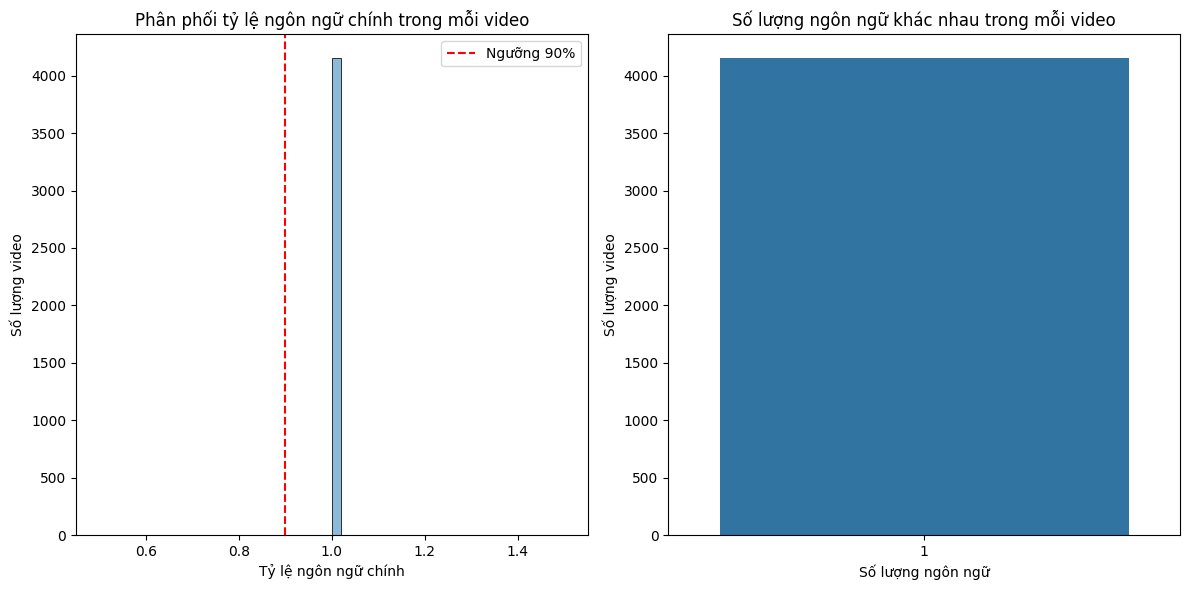

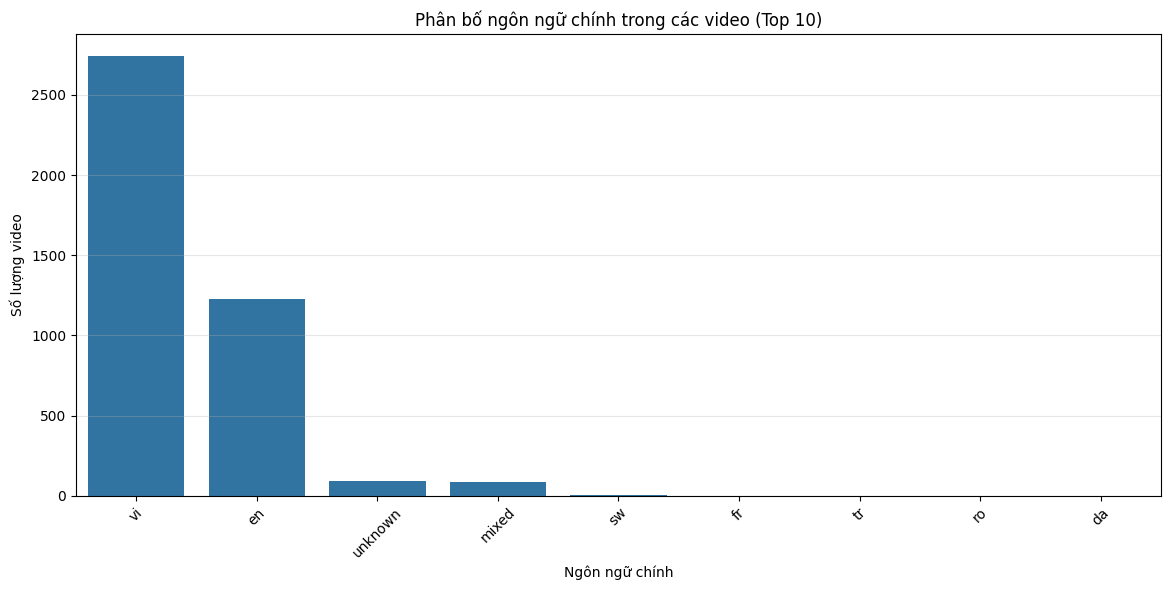

Số video có nhiều ngôn ngữ trộn lẫn (tỷ lệ ngôn ngữ chính < 90%): 0


In [10]:
# Tính toán phân bố ngôn ngữ theo từng video
language_distribution_by_video = df_vietnamese_transcript.groupby('video_id')['predicted_language'].value_counts(normalize=True).unstack().fillna(0)

# Chuyển đổi để có tỷ lệ ngôn ngữ chính trong mỗi video
primary_language_ratio = language_distribution_by_video.max(axis=1)

# Tính số lượng ngôn ngữ khác nhau trong mỗi video
language_count_by_video = df_vietnamese_transcript.groupby('video_id')['predicted_language'].nunique()

# Tạo DataFrame để phân tích
video_language_stats = pd.DataFrame({
    'primary_language_ratio': primary_language_ratio,
    'language_count': language_count_by_video
})

# Thêm thông tin ngôn ngữ chính
video_language_stats['primary_language'] = language_distribution_by_video.idxmax(axis=1)

# Vẽ biểu đồ phân phối tỷ lệ ngôn ngữ chính
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(video_language_stats['primary_language_ratio'], bins=50, kde=True)
plt.title('Phân phối tỷ lệ ngôn ngữ chính trong mỗi video')
plt.xlabel('Tỷ lệ ngôn ngữ chính')
plt.ylabel('Số lượng video')
plt.axvline(0.9, color='red', linestyle='--', label='Ngưỡng 90%')
plt.legend()

# Vẽ biểu đồ số lượng ngôn ngữ khác nhau trong mỗi video
plt.subplot(1, 2, 2)
sns.countplot(x='language_count', data=video_language_stats)
plt.title('Số lượng ngôn ngữ khác nhau trong mỗi video')
plt.xlabel('Số lượng ngôn ngữ')
plt.ylabel('Số lượng video')

plt.tight_layout()
plt.show()

# Vẽ biểu đồ phân bố ngôn ngữ chính
plt.figure(figsize=(14, 6))
language_counts = video_language_stats['primary_language'].value_counts()
top_languages = language_counts.head(10)

sns.barplot(x=top_languages.index, y=top_languages.values)
plt.title('Phân bố ngôn ngữ chính trong các video (Top 10)')
plt.xlabel('Ngôn ngữ chính')
plt.ylabel('Số lượng video')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Phân tích cụ thể cho video có nhiều ngôn ngữ
mixed_language_videos = video_language_stats[video_language_stats['primary_language_ratio'] < 0.9]
print(f"Số video có nhiều ngôn ngữ trộn lẫn (tỷ lệ ngôn ngữ chính < 90%): {len(mixed_language_videos)}")

# Chọn một video ví dụ để trực quan hóa
if len(mixed_language_videos) > 0:
    example_video_id = mixed_language_videos.index[0]
    example_video_data = df_vietnamese_transcript[df_vietnamese_transcript['video_id'] == example_video_id]
    
    plt.figure(figsize=(12, 6))
    
    # Biểu đồ phân bố ngôn ngữ theo trình tự thời gian
    plt.scatter(example_video_data['start'], 
                [1 if lang == 'vi' else 0 for lang in example_video_data['predicted_language']], 
                c=[plt.cm.Set1(i) for i in range(len(example_video_data))],
                alpha=0.7)
    plt.title(f'Phân bố ngôn ngữ theo thời gian trong video {example_video_id}')
    plt.xlabel('Thời gian (giây)')
    plt.yticks([0, 1], ['Ngôn ngữ khác', 'Tiếng Việt'])
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Hiển thị bảng phân bố ngôn ngữ chi tiết cho video này
    language_dist = example_video_data['predicted_language'].value_counts(normalize=True) * 100
    print(f"\nPhân bố ngôn ngữ trong video {example_video_id}:")
    for lang, percentage in language_dist.items():
        print(f"{lang}: {percentage:.2f}%")

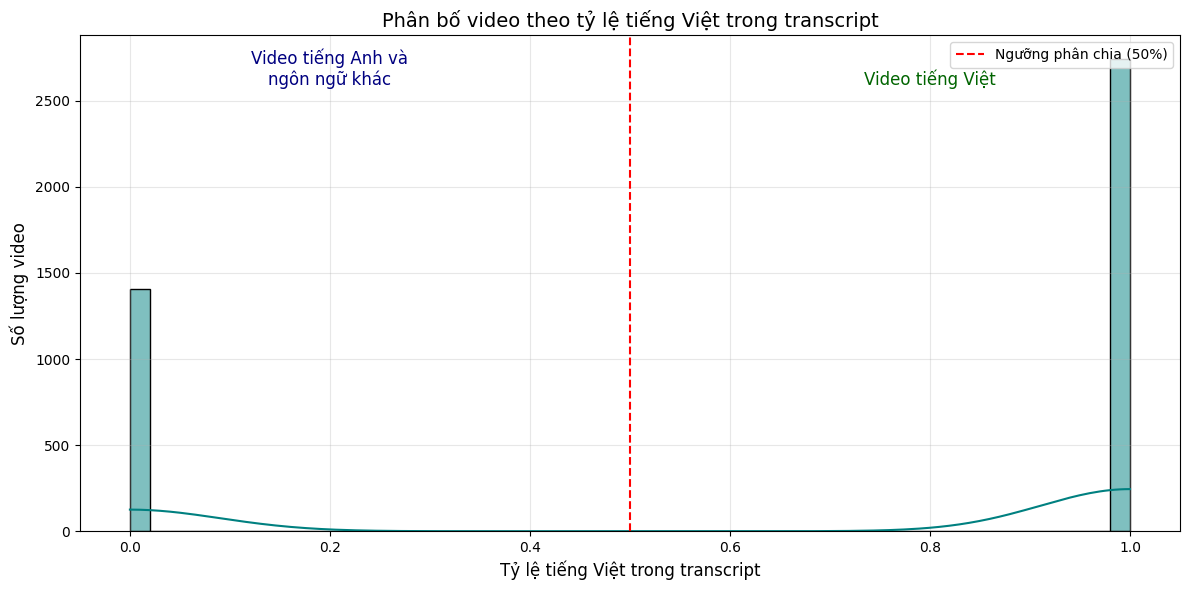

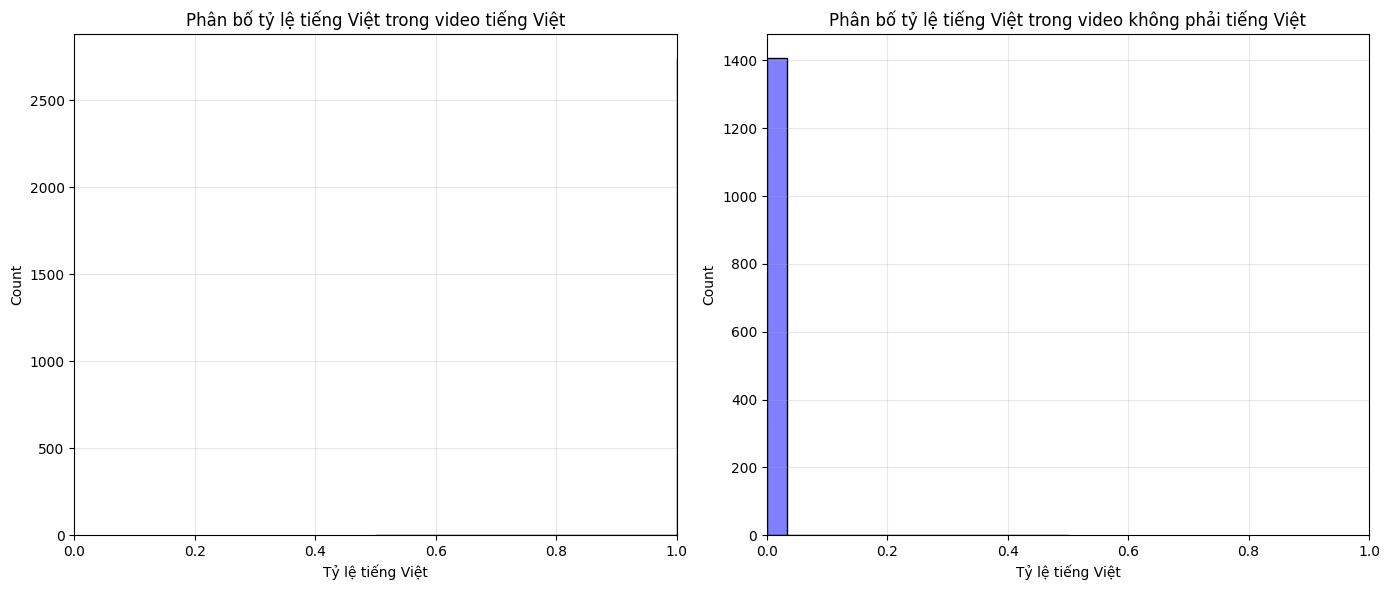

Tổng số video: 4151
Video tiếng Việt: 2743 (66.08%)
Video không phải tiếng Việt: 1408 (33.92%)

Phân bố các ngôn ngữ không phải tiếng Việt:
predicted_language
en         259442
mixed       13237
unknown      3258
ro             82
da             62
fr             25
sw             16
tr              1
Name: count, dtype: int64


In [11]:
# Phân tích video dựa trên tỷ lệ tiếng Việt trong transcript
# Tính tỷ lệ tiếng Việt trong mỗi video
vietnamese_ratio = df_vietnamese_transcript.groupby('video_id')['predicted_language'].apply(
    lambda x: (x == 'vi').mean()
)

# Tạo biểu đồ phân bố tỷ lệ tiếng Việt
plt.figure(figsize=(12, 6))

# Biểu đồ histogram với KDE để thể hiện rõ các đỉnh
sns.histplot(vietnamese_ratio, bins=50, kde=True, color='teal')
plt.title('Phân bố video theo tỷ lệ tiếng Việt trong transcript', fontsize=14)
plt.xlabel('Tỷ lệ tiếng Việt trong transcript', fontsize=12)
plt.ylabel('Số lượng video', fontsize=12)

# Thêm đường phân chia ngưỡng
plt.axvline(0.5, color='red', linestyle='--', label='Ngưỡng phân chia (50%)')

# Thêm chú thích
plt.annotate('Video tiếng Anh và\nngôn ngữ khác', xy=(0.2, plt.gca().get_ylim()[1]*0.9), 
             fontsize=12, ha='center', color='navy')
plt.annotate('Video tiếng Việt', xy=(0.8, plt.gca().get_ylim()[1]*0.9), 
             fontsize=12, ha='center', color='darkgreen')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tạo biểu đồ phân tích cụ thể hơn với phân loại rõ ràng
# Phân loại video
video_languages = pd.DataFrame({
    'vietnamese_ratio': vietnamese_ratio
})
video_languages['primary_language'] = np.where(video_languages['vietnamese_ratio'] > 0.5, 'Vietnamese', 'Non-Vietnamese')

# Biểu đồ thứ hai: Hiển thị phân bố trong từng nhóm
plt.figure(figsize=(14, 6))

# Subplot cho video tiếng Việt
plt.subplot(1, 2, 1)
sns.histplot(video_languages[video_languages['primary_language'] == 'Vietnamese']['vietnamese_ratio'], 
             bins=30, kde=True, color='green')
plt.title('Phân bố tỷ lệ tiếng Việt trong video tiếng Việt', fontsize=12)
plt.xlabel('Tỷ lệ tiếng Việt')
plt.xlim(0, 1)
plt.grid(alpha=0.3)

# Subplot cho video không phải tiếng Việt
plt.subplot(1, 2, 2)
sns.histplot(video_languages[video_languages['primary_language'] == 'Non-Vietnamese']['vietnamese_ratio'], 
             bins=30, kde=True, color='blue')
plt.title('Phân bố tỷ lệ tiếng Việt trong video không phải tiếng Việt', fontsize=12)
plt.xlabel('Tỷ lệ tiếng Việt')
plt.xlim(0, 1)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Phân tích tỷ lệ phân phối
vietnamese_videos = len(video_languages[video_languages['primary_language'] == 'Vietnamese'])
non_vietnamese_videos = len(video_languages[video_languages['primary_language'] == 'Non-Vietnamese'])
total_videos = len(video_languages)

print(f'Tổng số video: {total_videos}')
print(f'Video tiếng Việt: {vietnamese_videos} ({vietnamese_videos/total_videos*100:.2f}%)')
print(f'Video không phải tiếng Việt: {non_vietnamese_videos} ({non_vietnamese_videos/total_videos*100:.2f}%)')

# Phân tích tiếng Anh và các ngôn ngữ khác không phải tiếng Việt
non_vi_languages = df_vietnamese_transcript[df_vietnamese_transcript['predicted_language'] != 'vi']['predicted_language'].value_counts()
print("\nPhân bố các ngôn ngữ không phải tiếng Việt:")
print(non_vi_languages.head(10))

In [12]:
# lưu lại dataset mới chỉ có tiếng Việt đã được đảm bảo
vietnamese_transcript_path = os.path.join(output_folder, 'processed_transcript_vietnamese.parquet')
df_vietnamese_transcript.to_parquet(vietnamese_transcript_path, index=False)
print(f"Đã lưu dữ liệu transcript tiếng Việt đã xử lý tại: {vietnamese_transcript_path}")

Đã lưu dữ liệu transcript tiếng Việt đã xử lý tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\processed_transcript_vietnamese.parquet


In [13]:
# Đọc lại dữ liệu transcript tiếng Việt
df_vietnamese_transcript = pd.read_parquet(vietnamese_transcript_path)
print(f"Số lượng video có transcript tiếng Việt: {df_vietnamese_transcript['video_id'].nunique()}")

df_vietnamese_transcript.head(3)

Số lượng video có transcript tiếng Việt: 4151


,video_id,start,end,duration,text,language_code,language_name,is_generated,predicted_language
0,--1melFLS10,0.00,10.92,10.92,a Vision of doubt and me right testas,vi,Vietnamese (auto-generated),True,en
1,--1melFLS10,7.01,14.40,7.39,bliss Wonders are on the left us in the,vi,Vietnamese (auto-generated),True,en
2,--1melFLS10,10.92,18.69,7.77,study of rebirth of president to have,vi,Vietnamese (auto-generated),True,en


In [20]:
# Bước 1: Tính tỷ lệ tiếng Việt cho mỗi video
vietnamese_ratio = df_vietnamese_transcript.groupby('video_id')['predicted_language'].apply(
    lambda x: (x == 'vi').mean()
)

# Bước 2: In ra để kiểm tra phân bố tỷ lệ
print("Phân bố tỷ lệ tiếng Việt trong các video:")
print(vietnamese_ratio.describe())

# Bước 3: Tạo một DataFrame chứa thông tin về tỷ lệ
video_language_info = pd.DataFrame({'vietnamese_ratio': vietnamese_ratio})

# Bước 4: Lọc các video có tỷ lệ tiếng Việt > 0.5
true_vietnamese_videos = video_language_info[video_language_info['vietnamese_ratio'] > 0.5]

# Bước 5: Lấy danh sách video ID
vietnamese_video_ids = true_vietnamese_videos.index.tolist()

# Bước 6: Kiểm tra các video có tỷ lệ tiếng Việt thấp nhất trong danh sách đã chọn
print("\nKiểm tra 10 video có tỷ lệ tiếng Việt thấp nhất trong danh sách được chọn:")
lowest_vi_ratio = true_vietnamese_videos.sort_values('vietnamese_ratio').head(10)
print(lowest_vi_ratio)

# Lọc dữ liệu để lấy tất cả transcript từ các video tiếng Việt
df_vietnamese_transcript_full = df_vietnamese_transcript[df_vietnamese_transcript['video_id'].isin(vietnamese_video_ids)]

Phân bố tỷ lệ tiếng Việt trong các video:
count    4151.000000
mean        0.660805
std         0.473493
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: predicted_language, dtype: float64

Kiểm tra 10 video có tỷ lệ tiếng Việt thấp nhất trong danh sách được chọn:
             vietnamese_ratio
video_id                     
ziotSaBtqGk               1.0
zihGmTsmwMA               1.0
zid-MVo7M-E               1.0
ziUMJB3id8I               1.0
zhRtE5nzVGI               1.0
zfttRfTmtuE               1.0
zfXbi794Vk0               1.0
zeDvEudfCkg               1.0
ze5yTy0WFns               1.0
zdukWtJwlPU               1.0


In [ ]:

# Lưu lại dữ liệu transcript tiếng Việt đã lọc
vietnamese_transcript_full_path = os.path.join(output_folder, 'processed_transcript_vietnamese_full.parquet')
df_vietnamese_transcript_full.to_parquet(vietnamese_transcript_full_path, index=False)
print(f"Đã lưu dữ liệu transcript tiếng Việt đã lọc tại: {vietnamese_transcript_full_path}")

Đã lưu dữ liệu transcript tiếng Việt đã lọc tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\processed_transcript_vietnamese_full.parquet


In [3]:
# Đọc lại dữ liệu transcript tiếng Việt đã lọc
vietnamese_transcript_full_path = os.path.join(output_folder, 'processed_transcript_vietnamese_full.parquet')
df_vietnamese_transcript_full = pd.read_parquet(vietnamese_transcript_full_path)
# Kiểm tra số lượng video và đoạn transcript
print(f"Số lượng video có transcript tiếng Việt: {df_vietnamese_transcript_full['video_id'].nunique()}")
print(f"Số lượng đoạn transcript tiếng Việt: {len(df_vietnamese_transcript_full)}")
df_vietnamese_transcript_full.head(3)

Số lượng video có transcript tiếng Việt: 2743
Số lượng đoạn transcript tiếng Việt: 641500


,video_id,start,end,duration,text,language_code,language_name,is_generated,predicted_language
0,-3jXY2YZ-wM,0.000,23.609,23.609,a Vietnamese nước Úc được xe đậu trước,vi,Vietnamese (auto-generated),True,vi
1,-3jXY2YZ-wM,3.689,25.439,21.750,vị đệm chiếu trúc mặt là Tết vết sẹo lớn,vi,Vietnamese (auto-generated),True,vi
2,-3jXY2YZ-wM,23.609,27.510,3.901,trong tim cùng đôi bàn chân giờ đã đau,vi,Vietnamese (auto-generated),True,vi


In [4]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa
pf = ParquetFile(r"C:\Users\caotr\Downloads\transcript_data\sponsorTimes.parquet")
batch1 = next(pf.iter_batches(batch_size=1e6))
sponsor_df = pa.Table.from_batches([batch1]).to_pandas()
sponsor_df.head()

,videoID,startTime,endTime,votes,locked,incorrectVotes,UUID,userID,timeSubmitted,views,category,actionType,service,videoDuration,hidden,reputation,shadowHidden,hashedVideoID,userAgent,description
0,1rb3bMvDdX4,588.94100,631.89777,159,0,1,28aff450-a372-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,4642,sponsor,skip,YouTube,0.0,0,0.0,0,95e409452186a56331b7a58d518361285e18b8db50de20...,None,None
1,fBxtS9BpVWs,41.00000,53.00000,115,0,1,b2465943-1313-449c-b75c-08b14756ac0a,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,776,sponsor,skip,YouTube,0.0,0,0.0,0,bdd81b2b8192683242fe3608c45d5b958ddc71e9b2981a...,None,None
2,9P6rdqiybaw,488.52150,542.11035,-2,0,1,81024780-a367-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,25661,sponsor,skip,YouTube,552.0,0,0.0,0,cc9cd26ee245cb89f2be13d047de8ea1a642c8f56bcb6e...,None,None
3,ulCdoCfw-bY,487.50198,547.48750,-2,0,1,16090680-a367-11e9-b256-cb886cabe693,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,26984,sponsor,skip,YouTube,0.0,0,0.0,0,177779136cde894988da5e2d3160ef38d302a8554d710d...,None,None
4,uqKGREZs6-w,475.52167,532.20874,302,0,1,622f9270-a2a1-11e9-b210-99c885575bb9,38e7c2af-09f4-4492-bf49-75e443962ccd,1564088876715,18060,sponsor,skip,YouTube,0.0,1,0.0,0,70f8d0e75affa202ab510bd86828080af1dddf9218be46...,None,None


In [5]:
# Lọc ra các sponsorblock videoID thuộc về các video tiếng Việt
vietnamese_video_ids = df_vietnamese_transcript_full['video_id'].unique()
sponsor_df = sponsor_df[sponsor_df['videoID'].isin(vietnamese_video_ids)]
# Lưu lại dữ liệu sponsorblock đã lọc
sponsor_path = os.path.join(output_folder, 'sponsorblock_vietnamese.parquet')
sponsor_df.to_parquet(sponsor_path, index=False)
print(f"Đã lưu dữ liệu sponsorblock đã lọc tại: {sponsor_path}")


Đã lưu dữ liệu sponsorblock đã lọc tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\sponsorblock_vietnamese.parquet


In [6]:
# Đọc lại dữ liệu sponsorblock đã lọc
sponsor_path = os.path.join(output_folder, 'sponsorblock_vietnamese.parquet')
sponsor_df = pd.read_parquet(sponsor_path)
# Kiểm tra số lượng video và đoạn sponsorblock
print(f"Số lượng video có sponsorblock: {sponsor_df['videoID'].nunique()}")
print(f"Số lượng đoạn sponsorblock: {len(sponsor_df)}")

Số lượng video có sponsorblock: 2743
Số lượng đoạn sponsorblock: 4785


In [10]:
def clean_sponsorblock_data(sponsor_df):
    """
    Xử lý dữ liệu SponsorBlock để loại bỏ các trường hợp segment chồng chéo mà không dùng IntervalTree
    
    Args:
        sponsor_df: DataFrame chứa dữ liệu SponsorBlock
    
    Returns:
        DataFrame: Dữ liệu đã xử lý, không còn segment chồng chéo
    """
    print("Trước khi xử lý:", sponsor_df.shape)
    
    # 1. Loại bỏ các dòng có videoID null, hidden hoặc shadowHidden = 1
    sponsor_df = sponsor_df.dropna(subset=['videoID'])
    sponsor_df = sponsor_df[(sponsor_df['hidden'] == 0) & (sponsor_df['shadowHidden'] == 0)]
    
    # 2. Chỉ giữ lại các trường cần thiết
    necessary_columns = ['videoID', 'startTime', 'endTime', 'votes', 'locked', 'category', 'actionType']
    sponsor_df = sponsor_df[necessary_columns].copy()
    
    # 3. Loại bỏ các dòng có startTime hoặc endTime không hợp lệ
    sponsor_df = sponsor_df[(sponsor_df['startTime'] >= 0) & (sponsor_df['endTime'] > sponsor_df['startTime'])]
    
    print("Sau khi lọc sơ bộ:", sponsor_df.shape)
    
    # 4. Xử lý các segment chồng chéo theo từng video
    result_segments = []
    
    for video_id, group in tqdm(sponsor_df.groupby('videoID'), desc="Xử lý segment chồng chéo"):
        if len(group) <= 1:
            result_segments.append(group)
            continue
        
        # Sắp xếp theo mức độ ưu tiên: locked > votes > startTime
        sorted_segments = group.sort_values(
            by=['locked', 'votes', 'startTime'], 
            ascending=[False, False, True]
        )
        
        kept_segments = []
        for idx, row in sorted_segments.iterrows():
            start = row['startTime']
            end = row['endTime']
            overlap_found = False
            for kept in kept_segments:
                kept_start = kept['startTime']
                kept_end = kept['endTime']
                # Kiểm tra chồng lấp
                overlap_start = max(start, kept_start)
                overlap_end = min(end, kept_end)
                overlap_length = overlap_end - overlap_start
                if overlap_length > 0:
                    segment_length = min(end - start, kept_end - kept_start)
                    if overlap_length / segment_length > 0.5:
                        overlap_found = True
                        break
            if not overlap_found:
                kept_segments.append(row)
        if kept_segments:
            result_segments.append(pd.DataFrame(kept_segments))
    
    clean_df = pd.concat(result_segments, ignore_index=True)
    print("Sau khi xử lý chồng chéo:", clean_df.shape)
    return clean_df


In [15]:
# Đọc lại dữ liệu sponsorblock
sponsor_path = os.path.join(output_folder, 'sponsorblock_vietnamese.parquet')
sponsor_df = pd.read_parquet(sponsor_path)

# Xử lý sponsorblock để loại bỏ overlap
cleaned_sponsor_df = clean_sponsorblock_data(sponsor_df)

# Lưu kết quả đã xử lý
cleaned_sponsor_path = os.path.join(output_folder, 'sponsorblock_vietnamese_cleaned.parquet')
cleaned_sponsor_df.to_parquet(cleaned_sponsor_path, index=False)
print(f"Đã lưu dữ liệu SponsorBlock đã xử lý tại: {cleaned_sponsor_path}")

Trước khi xử lý: (4785, 20)
Sau khi lọc sơ bộ: (4707, 7)


Xử lý segment chồng chéo: 100%|██████████| 2732/2732 [00:00<00:00, 4014.94it/s]


Sau khi xử lý chồng chéo: (4419, 7)
Đã lưu dữ liệu SponsorBlock đã xử lý tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\sponsorblock_vietnamese_cleaned.parquet


In [17]:
def label_transcripts(transcript_df, sponsor_df):
    """
    Gán nhãn đơn giản cho transcript với tối ưu hóa vector: 
    Nếu đoạn transcript có bất kỳ chồng lấp nào với segment sponsor, gán nhãn is_sponsor = 1.
    Thêm cột category (nếu có overlap thì lấy category sponsor, không thì NaN).
    """
    sponsor_dict = defaultdict(list)
    for _, row in sponsor_df.iterrows():
        sponsor_dict[row['videoID']].append((row['startTime'], row['endTime'], row['category']))
    
    transcript_df['is_sponsor'] = 0
    transcript_df['category'] = np.nan

    batch_size = 10000
    num_batches = (len(transcript_df) + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches), desc="Gán nhãn (phương pháp đơn giản)"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(transcript_df))
        batch = transcript_df.iloc[start_idx:end_idx]

        for video_id, video_group in batch.groupby('video_id'):
            if video_id not in sponsor_dict:
                continue
            sponsor_segments = sponsor_dict[video_id]
            if not sponsor_segments:
                continue
            indices = video_group.index
            for sponsor_start, sponsor_end, sponsor_cat in sponsor_segments:
                has_overlap = (
                    (video_group['start'] < sponsor_end) & (video_group['end'] > sponsor_start)
                )
                transcript_df.loc[indices[has_overlap], 'is_sponsor'] = 1
                # Gán category cho các đoạn overlap (ưu tiên category đầu tiên nếu overlap nhiều)
                transcript_df.loc[indices[has_overlap], 'category'] = sponsor_cat

    return transcript_df


In [18]:
transcript_df = pd.read_parquet(vietnamese_transcript_full_path)
# Gán nhãn cho transcript
labeled_transcript_df = label_transcripts(transcript_df, cleaned_sponsor_df)
# Lưu lại transcript đã gán nhãn
labeled_transcript_df_path = os.path.join(output_folder, 'labeled_transcript_vietnamese.parquet')
labeled_transcript_df.to_parquet(labeled_transcript_df_path, index=False)
print(f"Đã lưu dữ liệu transcript đã gán nhãn tại: {labeled_transcript_df_path}")


Gán nhãn (phương pháp đơn giản):   0%|          | 0/65 [00:00<?, ?it/s]C:\Users\caotr\AppData\Local\Temp\ipykernel_7000\3344948664.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'sponsor' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  transcript_df.loc[indices[has_overlap], 'category'] = sponsor_cat
Gán nhãn (phương pháp đơn giản): 100%|██████████| 65/65 [00:01<00:00, 45.20it/s]


Đã lưu dữ liệu transcript đã gán nhãn tại: C:\Users\caotr\Documents\Github\Nh-m-4---IE403.KTDLTTXH\data_raw\labeled_transcript_vietnamese.parquet


In [19]:
# Đọc lại dữ liệu transcript đã gán nhãn
labeled_transcript_df = pd.read_parquet(labeled_transcript_df_path)
# Kiểm tra số lượng video và đoạn transcript
print(f"Số lượng video có transcript đã gán nhãn: {labeled_transcript_df['video_id'].nunique()}")
print(f"Số lượng đoạn transcript đã gán nhãn: {len(labeled_transcript_df)}")
# Kiểm tra phân bố nhãn
print(f"Phân bố nhãn is_sponsor:\n{labeled_transcript_df['is_sponsor'].value_counts(normalize=True)}")
# Hiển thị một số dòng đầu tiên của dữ liệu đã gán nhãn
labeled_transcript_df.head(3)

Số lượng video có transcript đã gán nhãn: 2743
Số lượng đoạn transcript đã gán nhãn: 641500
Phân bố nhãn is_sponsor:
is_sponsor
0    0.954661
1    0.045339
Name: proportion, dtype: float64


,video_id,start,end,duration,text,language_code,language_name,is_generated,predicted_language,is_sponsor,category
0,-3jXY2YZ-wM,0.000,23.609,23.609,a Vietnamese nước Úc được xe đậu trước,vi,Vietnamese (auto-generated),True,vi,1,sponsor
1,-3jXY2YZ-wM,3.689,25.439,21.750,vị đệm chiếu trúc mặt là Tết vết sẹo lớn,vi,Vietnamese (auto-generated),True,vi,1,sponsor
2,-3jXY2YZ-wM,23.609,27.510,3.901,trong tim cùng đôi bàn chân giờ đã đau,vi,Vietnamese (auto-generated),True,vi,0,None


In [20]:
# lưu dữ liệu dưới dạng csv
labeled_transcript_df.to_csv(r"C:\Users\caotr\Downloads\transcript_data\labeled_transcript_vietnamese.csv", index=False)

## 4. Gán nhãn cho transcript bằng cách kết hợp với dữ liệu SponsorBlock

In [ ]:
def label_transcripts(transcript_df, sponsor_df):
    """
    Gán nhãn cho transcript dựa trên dữ liệu SponsorBlock
    Phiên bản tối ưu sử dụng phương pháp xử lý theo batch
    """
    # Tạo dictionary lưu thông tin sponsor theo video_id
    sponsor_dict = defaultdict(list)
    for _, row in sponsor_df.iterrows():
        sponsor_dict[row['videoID']].append((row['startTime'], row['endTime']))
    
    # Thêm cột is_sponsor vào DataFrame transcript
    transcript_df['is_sponsor'] = 0
    
    # Xử lý theo batch để tối ưu hiệu suất
    batch_size = 10000  # Điều chỉnh kích thước batch tùy theo RAM
    num_batches = (len(transcript_df) + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="Gán nhãn (theo batch)"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(transcript_df))
        batch = transcript_df.iloc[start_idx:end_idx]
        
        # Xử lý từng video trong batch
        for video_id, video_group in batch.groupby('video_id'):
            # Kiểm tra xem video có trong danh sách sponsor không
            if video_id not in sponsor_dict:
                continue
                
            # Lấy danh sách các segment sponsor cho video này
            sponsor_segments = sponsor_dict[video_id]
            if not sponsor_segments:
                continue
                
            # Lấy indices của video_group trong transcript_df
            indices = video_group.index
            
            # Xử lý từng sponsor segment
            for sponsor_start, sponsor_end in sponsor_segments:
                # Điều kiện sponsor (sử dụng phép toán vector)
                is_sponsor = (
                    ((video_group['start'] >= sponsor_start) & (video_group['start'] < sponsor_end)) |  # start trong sponsor
                    ((video_group['end'] > sponsor_start) & (video_group['end'] <= sponsor_end)) |      # end trong sponsor
                    ((video_group['start'] <= sponsor_start) & (video_group['end'] >= sponsor_end))     # bao quanh sponsor
                )
                
                # Cập nhật nhãn
                transcript_df.loc[indices[is_sponsor], 'is_sponsor'] = 1
    
    return transcript_df

# Gán nhãn cho transcript
labeled_transcript_df = label_transcripts(transcript_df, cleaned_sponsor_df)

# Hiển thị thông tin
print(f"Tổng số dòng: {len(labeled_transcript_df)}")
print(f"Số dòng được gán nhãn sponsor (is_sponsor=1): {labeled_transcript_df['is_sponsor'].sum()}")
print(f"Tỷ lệ sponsor: {labeled_transcript_df['is_sponsor'].mean() * 100:.2f}%")

# Phân tích theo ngôn ngữ
print("\n===== THỐNG KÊ SPONSOR THEO NGÔN NGỮ =====")
language_stats = labeled_transcript_df.groupby('language_code')['is_sponsor'].agg(['count', 'sum', 'mean'])
language_stats = language_stats.sort_values('count', ascending=False)
language_stats['mean'] = language_stats['mean'] * 100  # Chuyển thành tỷ lệ phần trăm
print(language_stats.rename(columns={'count': 'Tổng số đoạn', 'sum': 'Số đoạn sponsor', 'mean': 'Tỷ lệ sponsor (%)'}));

# Lưu DataFrame đã gán nhãn
labeled_path = os.path.join(output_folder, 'transcript_segments_labeled_all_languages.parquet')
labeled_transcript_df.to_parquet(labeled_path, index=False)
print(f"Đã lưu dữ liệu transcript đã gán nhãn tại: {labeled_path}")

## 5. Phân tích dữ liệu đã gán nhãn

In [ ]:
# Phân tích dữ liệu đã gán nhãn
print("===== THỐNG KÊ DỮ LIỆU ĐÃ GÁN NHÃN =====")
print(f"Số lượng video: {labeled_transcript_df['video_id'].nunique()}")
print(f"Số lượng đoạn text: {len(labeled_transcript_df)}")
print(f"Số lượng đoạn sponsor: {labeled_transcript_df['is_sponsor'].sum()}")
print(f"Tỷ lệ sponsor tổng thể: {labeled_transcript_df['is_sponsor'].mean() * 100:.2f}%")
print(f"Số ngôn ngữ: {labeled_transcript_df['language_code'].nunique()}")

# Phân tích độ dài văn bản
labeled_transcript_df['text_length'] = labeled_transcript_df['text'].str.len()

# Phân tích theo nhãn
sponsor_segments = labeled_transcript_df[labeled_transcript_df['is_sponsor'] == 1]
non_sponsor_segments = labeled_transcript_df[labeled_transcript_df['is_sponsor'] == 0]

print("\n===== THỐNG KÊ THEO NHÃN =====")
print("Đoạn sponsor:")
print(f"- Số lượng: {len(sponsor_segments)}")
print(f"- Thời lượng trung bình: {sponsor_segments['duration'].mean():.2f} giây")
print(f"- Độ dài văn bản trung bình: {sponsor_segments['text_length'].mean():.2f} ký tự")

print("\nĐoạn không phải sponsor:")
print(f"- Số lượng: {len(non_sponsor_segments)}")
print(f"- Thời lượng trung bình: {non_sponsor_segments['duration'].mean():.2f} giây")
print(f"- Độ dài văn bản trung bình: {non_sponsor_segments['text_length'].mean():.2f} ký tự")

# Phân tích chi tiết theo ngôn ngữ
print("\n===== THỐNG KÊ THEO NGÔN NGỮ =====")
top_langs = labeled_transcript_df['language_code'].value_counts().head(10)
print(f"Top 10 ngôn ngữ phổ biến nhất:\n{top_langs}")

# Thống kê chi tiết theo ngôn ngữ
lang_detailed_stats = labeled_transcript_df.groupby(['language_code', 'language_name'])['is_sponsor'].agg(['count', 'sum', 'mean'])
lang_detailed_stats['mean'] = lang_detailed_stats['mean'] * 100  # Chuyển thành tỷ lệ phần trăm
lang_detailed_stats = lang_detailed_stats.sort_values('count', ascending=False)
print("\nThống kê chi tiết theo ngôn ngữ (Top 20):")
print(lang_detailed_stats.head(20).rename(columns={'count': 'Tổng số đoạn', 'sum': 'Số đoạn sponsor', 'mean': 'Tỷ lệ sponsor (%)'}))

# Phân tích theo is_generated
print("\n===== THỐNG KÊ THEO IS_GENERATED =====")
gen_stats = labeled_transcript_df.groupby('is_generated')['is_sponsor'].agg(['count', 'sum', 'mean'])
gen_stats['mean'] = gen_stats['mean'] * 100  # Chuyển thành tỷ lệ phần trăm
print(gen_stats.rename(columns={'count': 'Tổng số đoạn', 'sum': 'Số đoạn sponsor', 'mean': 'Tỷ lệ sponsor (%)'}));

# Phân tích chi tiết kết hợp giữa ngôn ngữ và is_generated
print("\n===== THỐNG KÊ THEO NGÔN NGỮ VÀ IS_GENERATED =====")
combined_stats = labeled_transcript_df.groupby(['language_code', 'is_generated'])['is_sponsor'].agg(['count', 'sum', 'mean'])
combined_stats['mean'] = combined_stats['mean'] * 100  # Chuyển thành tỷ lệ phần trăm
combined_stats = combined_stats.sort_values(['language_code', 'is_generated'])
print("Thống kê cho các ngôn ngữ chính (Top 5) theo is_generated:")

# Lấy top 5 ngôn ngữ phổ biến nhất
top_5_langs = labeled_transcript_df['language_code'].value_counts().head(5).index
for lang in top_5_langs:
    print(f"\n{lang}:")
    subset = combined_stats.loc[lang]
    print(subset.rename(columns={'count': 'Tổng số đoạn', 'sum': 'Số đoạn sponsor', 'mean': 'Tỷ lệ sponsor (%)'}));

# Vẽ biểu đồ phân phối thời lượng
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.histplot(data=labeled_transcript_df, x='duration', hue='is_sponsor', multiple='stack', bins=50)
plt.title('Phân phối thời lượng theo nhãn')
plt.xlabel('Thời lượng (giây)')
plt.ylabel('Số lượng')

plt.subplot(2, 2, 2)
sns.histplot(data=labeled_transcript_df, x='text_length', hue='is_sponsor', multiple='stack', bins=50)
plt.title('Phân phối độ dài văn bản theo nhãn')
plt.xlabel('Số ký tự')
plt.ylabel('Số lượng')

# Phân tích theo ngôn ngữ - Tỷ lệ sponsor
plt.subplot(2, 2, 3)
lang_sponsor_ratio = labeled_transcript_df.groupby('language_code')['is_sponsor'].mean().sort_values(ascending=False).head(10) * 100
sns.barplot(x=lang_sponsor_ratio.index, y=lang_sponsor_ratio.values)
plt.title('Tỷ lệ sponsor theo ngôn ngữ (Top 10)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Tỷ lệ sponsor (%)')
plt.xticks(rotation=45)

# Phân tích theo is_generated
plt.subplot(2, 2, 4)
gen_sponsor_ratio = labeled_transcript_df.groupby('is_generated')['is_sponsor'].mean() * 100
sns.barplot(x=[str(x) for x in gen_sponsor_ratio.index], y=gen_sponsor_ratio.values)
plt.title('Tỷ lệ sponsor theo is_generated')
plt.xlabel('is_generated')
plt.ylabel('Tỷ lệ sponsor (%)')

plt.tight_layout()
plt.show()

# --- Thêm biểu đồ phân tích nâng cao ---

plt.figure(figsize=(16, 12))

# Biểu đồ phân bố số lượng segment theo ngôn ngữ
plt.subplot(2, 2, 1)
labeled_transcript_df['language_code'].value_counts().head(15).plot(kind='bar')
plt.title('Số lượng segment theo ngôn ngữ (Top 15)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Số lượng segment')
plt.xticks(rotation=45)

# Biểu đồ phân bố is_generated theo ngôn ngữ
plt.subplot(2, 2, 2)
# Tính tỷ lệ is_generated cho top 10 ngôn ngữ
top10_langs = labeled_transcript_df['language_code'].value_counts().head(10).index
gen_ratio_by_lang = labeled_transcript_df[labeled_transcript_df['language_code'].isin(top10_langs)].groupby('language_code')['is_generated'].mean() * 100
gen_ratio_by_lang.sort_values(ascending=False).plot(kind='bar')
plt.title('Tỷ lệ transcript tự động tạo theo ngôn ngữ (Top 10)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Tỷ lệ is_generated (%)')
plt.xticks(rotation=45)

# Biểu đồ so sánh thời lượng trung bình sponsor vs non-sponsor
plt.subplot(2, 2, 3)
avg_duration = pd.DataFrame({
    'Sponsor': sponsor_segments['duration'].mean(),
    'Non-Sponsor': non_sponsor_segments['duration'].mean()
}, index=['Thời lượng trung bình (giây)'])
avg_duration.T.plot(kind='bar')
plt.title('So sánh thời lượng trung bình')
plt.ylabel('Giây')

# Biểu đồ so sánh độ dài văn bản trung bình sponsor vs non-sponsor
plt.subplot(2, 2, 4)
# Phân tích theo top 5 ngôn ngữ
top5_langs = labeled_transcript_df['language_code'].value_counts().head(5).index
sponsor_ratio_top5 = labeled_transcript_df[labeled_transcript_df['language_code'].isin(top5_langs)]
sponsor_ratio_top5 = sponsor_ratio_top5.groupby(['language_code', 'is_generated'])['is_sponsor'].mean() * 100
sponsor_ratio_top5 = sponsor_ratio_top5.unstack()
sponsor_ratio_top5.plot(kind='bar')
plt.title('Tỷ lệ sponsor theo ngôn ngữ và is_generated (Top 5)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Tỷ lệ sponsor (%)')
plt.legend(title='is_generated')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --- Phân tích phân bố dữ liệu theo ngôn ngữ ---
plt.figure(figsize=(16, 8))

# Phân bố số lượng từ trong segment theo ngôn ngữ
plt.subplot(1, 2, 1)
top5_langs_data = labeled_transcript_df[labeled_transcript_df['language_code'].isin(top5_langs)]
sns.boxplot(x='language_code', y='text_length', data=top5_langs_data)
plt.title('Phân bố độ dài văn bản theo ngôn ngữ (Top 5)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Số ký tự')

# Phân bố thời lượng segment theo ngôn ngữ
plt.subplot(1, 2, 2)
sns.boxplot(x='language_code', y='duration', data=top5_langs_data)
plt.title('Phân bố thời lượng segment theo ngôn ngữ (Top 5)')
plt.xlabel('Ngôn ngữ')
plt.ylabel('Thời lượng (giây)')

plt.tight_layout()
plt.show()

## Tóm tắt quá trình xử lý

1. **Phân tích dữ liệu SponsorBlock**:
   - Dataset có 16.5 triệu dòng với 7.7 triệu video khác nhau
   - Phân tích phân phối thời gian, votes, hidden/shadowHidden
   - Phân tích các trường hợp video có nhiều segment

2. **Tiền xử lý dữ liệu SponsorBlock**:
   - Loại bỏ dòng có videoID null
   - Điền giá trị cho reputation bị null
   - Loại bỏ dòng có hidden hoặc shadowHidden = 1
   - Loại bỏ dòng có thời gian không hợp lệ
   - Loại bỏ segment quá dài
   - Xử lý segment chồng chéo, giữ lại segment có vote cao hơn

3. **Xử lý dữ liệu Transcript**:
   - Chuyển đổi các file JSON thành DataFrame cấu trúc
   - Xử lý tất cả các ngôn ngữ có trong transcript, không giới hạn ở tiếng Anh
   - Trích xuất thông tin về video_id, start, end, duration, text
   - Lưu giữ thông tin language_code, language_name và is_generated cho mỗi segment
   - Thu thập thông tin về tính chất auto-generated của transcript trong mỗi ngôn ngữ

4. **Gán nhãn cho Transcript (tối ưu hóa)**:
   - Gán nhãn is_sponsor dựa trên thông tin từ SponsorBlock
   - Sử dụng xử lý theo batch để tăng hiệu suất (giảm thời gian xử lý)
   - Áp dụng phép toán vector để phát hiện chồng lấp giữa segment và sponsor
   - Xử lý và gán nhãn cho tất cả các ngôn ngữ có trong transcript

5. **Phân tích dữ liệu đa ngôn ngữ**:
   - Thống kê về số lượng segment sponsor/không phải sponsor theo từng ngôn ngữ
   - Phân tích chi tiết về phân bố tỷ lệ sponsor cho top ngôn ngữ phổ biến
   - So sánh tỷ lệ sponsor theo ngôn ngữ và trạng thái is_generated
   - Phân tích mối tương quan giữa ngôn ngữ, trạng thái auto-generated và xác suất segment là sponsor
   - Hiển thị phân bố thời lượng và độ dài văn bản theo ngôn ngữ

6. **Trực quan hóa dữ liệu đa ngôn ngữ**:
   - Biểu đồ so sánh tỷ lệ sponsor theo ngôn ngữ
   - Biểu đồ phân bố số lượng segment theo ngôn ngữ
   - Biểu đồ tỷ lệ transcript tự động tạo theo ngôn ngữ
   - Biểu đồ phân tích ảnh hưởng của việc tạo tự động đến tỷ lệ nhận diện sponsor
   - Biểu đồ phân bố thời lượng và độ dài segment theo ngôn ngữ

Kết quả cuối cùng là một DataFrame chứa thông tin transcript đã được gán nhãn với đầy đủ thông tin về ngôn ngữ, được lưu dưới dạng Parquet, có thể được sử dụng để huấn luyện các mô hình phát hiện sponsor trên nhiều ngôn ngữ khác nhau.